<a href="https://colab.research.google.com/github/benjmcarthur/deep-learning/blob/master/multi-agent-ppo/Switch_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Download the required scripts and set up the environment

In [0]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

Cloning into 'ma-gym'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 792 (delta 21), reused 16 (delta 9), pack-reused 749
Receiving objects: 100% (792/792), 2.26 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/ma-gym
     |████████████████████████████████| 829kB 4.1MB/s 
     |████████████████████████████████| 1.6MB 15.0MB/s 
     |████████████████████████████████| 17.3MB 234kB/s 
     |████████████████████████████████| 2.1MB 57.1MB/s 
     |████████████████████████████████| 1.0MB 58.4MB/s 
     |████████████████████████████████| 25.2MB 44.1MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
ERROR: tensorflow-model-optimization 0.2.1 requires enum34~=1.1, which is not installed.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has require

Set up recording wrapper

In [0]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## PPO Agent

In [0]:
# Code based on example at: https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py

import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.done = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.done[:]

class ActorCritic(nn.Module):
    def __init__(self, d_state, n_actions):
        super(ActorCritic, self).__init__()
        hidden_layer_dim = 50

        # action function
        self.action_network = nn.Sequential(
                nn.Linear(d_state, hidden_layer_dim),
                nn.Tanh(),
                nn.Linear(hidden_layer_dim, hidden_layer_dim),
                nn.Tanh(),
                nn.Linear(hidden_layer_dim, n_actions),
                nn.Softmax(dim=-1)
                )
        
        # value estimation function
        self.value_network = nn.Sequential(
                nn.Linear(d_state, hidden_layer_dim),
                nn.Tanh(),
                nn.Linear(hidden_layer_dim, hidden_layer_dim),
                nn.Tanh(),
                nn.Linear(hidden_layer_dim, 1)
                )
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        action_probs = self.action_network(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_network(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_network(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

        
        
class PPO:
    def __init__(self, d_state, n_actions, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.step = 0
        
        self.policy = ActorCritic(d_state, n_actions).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(d_state, n_actions).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

        self.memory = Memory()

    def episode_start(self):
        self.step = 0

    def record(self, reward, done):
        self.step += 1
        self.memory.rewards.append(reward)
        self.memory.done.append(done)

    def act(self, state):
        # Create the model input [dim1, dim2, step]
        state = np.append(state, self.step)
        # Return the action from the old policy
        return self.policy_old.act(state, self.memory)

    def update(self):
        memory = self.memory   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, done in zip(reversed(memory.rewards), reversed(memory.done)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # Reset the memory
        self.memory.clear_memory()

## Switch2-v0



#### Train Agents

In [0]:
# creating environment
env = wrap_env(gym.make("Switch2-v0"))
d_state = 2
n_actions = 5
solved_reward = 7.4         # stop training if total_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 50000        # max training episodes
max_timesteps = 300         # max timesteps in one episode
update_timestep = 2000      # update policy every n timesteps (def 2000)
lr = 0.002                  # learning rate (def 0.002) try increasing?
betas = (0.9, 0.999)
gamma = 0.99                # discount factor (def 0.99)
K_epochs = 4                # update policy for K epochs (def 4)
eps_clip = 0.2              # clip parameter for PPO (def 0.2)
random_seed = None
n_agents = 2                # number of agents


if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

agents = [PPO(d_state+1, 
              n_actions, 
              lr, 
              betas, 
              gamma, 
              K_epochs, 
              eps_clip) for _ in range(n_agents)]

#print(lr,betas)
train_reward_1 = []
train_reward_2 = []
train_length = []
actions = [0, 0]

# logging variables
running_reward = [0, 0]
avg_length = 0
timestep = 0

# training loop
for i_episode in range(1, max_episodes+1):
    state_n = env.reset()
    for agent in agents: agent.episode_start()
    done_n = False
    t = 0
    while not np.all(done_n):
        timestep += 1
        
        # Running policy_old:
        actions = [agent.act(state) for agent, state in zip(agents, state_n)]

        # Get the state
        state_n, reward_n, done_n, _ = env.step(actions)

        # Saving reward and is_terminal:
        for agent, reward, done in zip(agents, reward_n, done_n):
            agent.record(reward, done)

        # update if its time
        if timestep % update_timestep == 0:
            for agent in agents:
              agent.update()
            timestep = 0
        
        running_reward = [running_reward[i] + reward_n[i] for i in range(n_agents)]
        t += 1
    
    # stop training if avg_reward > solved_reward
    av_reward = np.mean(train_reward_1[-int(log_interval):]) + np.mean(train_reward_2[-int(log_interval):])
    if av_reward > solved_reward: 
        print("Solved!! ")
        break

    # save results for training graph
    train_reward_1.append(running_reward[0])
    train_reward_2.append(running_reward[1])
    train_length.append(t)
    running_reward = [0,0]
    t = 0
        
    if i_episode % log_interval == 0:
          print('Episode {}: Agent 1 {:.3}, Agent 2: {:.3}, length {}'.format(i_episode,
                                                              np.mean(train_reward_1[-int(log_interval):]),
                                                              np.mean(train_reward_2[-int(log_interval):]),
                                                              np.mean(train_length[-int(log_interval):])))

#### Display Results

In [4]:
show_video()

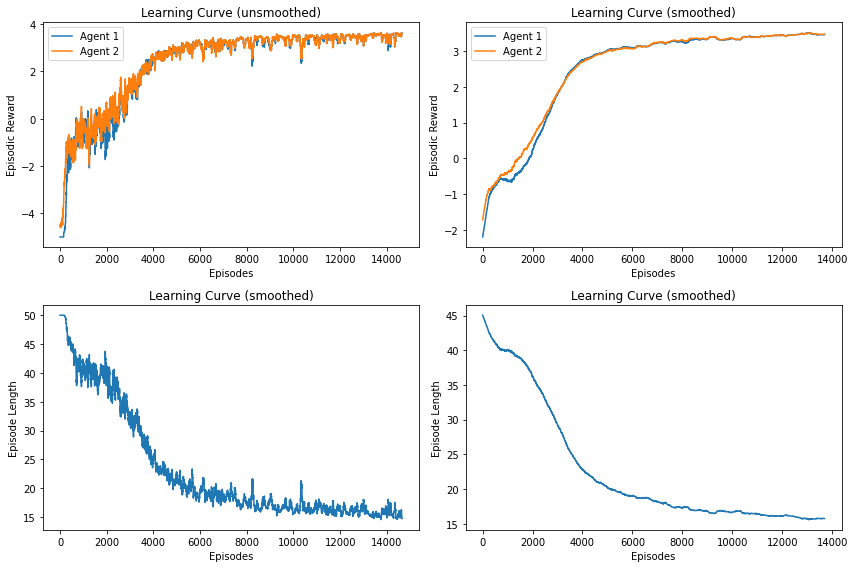

In [5]:
rough = 50
smooth = 1000

reward_rough_1 = np.convolve(train_reward_1, np.ones((rough,))/rough, mode='valid')
reward_smooth_1 = np.convolve(train_reward_1, np.ones((smooth,))/smooth, mode='valid')

reward_rough_2 = np.convolve(train_reward_2, np.ones((rough,))/rough, mode='valid')
reward_smooth_2 = np.convolve(train_reward_2, np.ones((smooth,))/smooth, mode='valid')

length_rough = np.convolve(train_length, np.ones((rough,))/rough, mode='valid')
length_smooth = np.convolve(train_length, np.ones((smooth,))/smooth, mode='valid')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2,2,1)
ax.plot(reward_rough_1, label='Agent 1')
ax.plot(reward_rough_2, label='Agent 2')
ax.set_title("Learning Curve (unsmoothed)")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes")
ax.legend()

ax = fig.add_subplot(2,2,2)
ax.plot(reward_smooth_1, label='Agent 1')
ax.plot(reward_smooth_2, label='Agent 2')
ax.set_title("Learning Curve (smoothed)")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes")
ax.legend()

ax = fig.add_subplot(2,2,3)
ax.plot(length_rough)
ax.set_title("Learning Curve (smoothed)")
ax.set_ylabel("Episode Length")
ax.set_xlabel("Episodes")

ax = fig.add_subplot(2,2,4)
ax.plot(length_smooth)
ax.set_title("Learning Curve (smoothed)")
ax.set_ylabel("Episode Length")
ax.set_xlabel("Episodes")

plt.tight_layout()
plt.show()

## Switch4-v0

#### Train Agents

In [0]:
# Uses the same agent as defined for Switch2-v0

# creating environment
env = wrap_env(gym.make("Switch4-v0"))
d_state = 2
n_actions = 5
solved_reward = 14          # stop training if avg_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 50000        # max training episodes
max_timesteps = 300         # max timesteps in one episode
update_timestep = 2000      # update policy every n timesteps (def 2000)
lr = 0.002                  # learning rate (def 0.002) try increasing?
betas = (0.9, 0.999)
gamma = 0.99                # discount factor (def 0.99)
K_epochs = 4                # update policy for K epochs (def 4)
eps_clip = 0.2              # clip parameter for PPO (def 0.2)
random_seed = None
n_agents = 4                # number of agents

if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

agents = [PPO(d_state+1, n_actions, lr, betas, gamma, K_epochs, eps_clip) for _ in range(n_agents)]
actions = [0, 0, 0, 0]
train_reward_1 = []
train_reward_2 = []
train_reward_3 = []
train_reward_4 = []
train_length = []


# logging variables
running_reward = [0, 0, 0, 0]
avg_length = 0
timestep = 0

# training loop
for i_episode in range(1, max_episodes+1):
    state_n = env.reset()
    for agent in agents: agent.episode_start()
    done_n = False
    t = 0
    while not np.all(done_n):
        timestep += 1
        
        # Running policy_old:
        actions = [agent.act(state) for agent, state in zip(agents, state_n)]

        # Get the state
        state_n, reward_n, done_n, _ = env.step(actions)

        # Saving reward and is_terminal:
        for agent, reward, done in zip(agents, reward_n, done_n):
            agent.record(reward, done)

        # update if its time
        if timestep % update_timestep == 0:
            for agent in agents:
              agent.update()
            timestep = 0
        
        running_reward = [running_reward[i] + reward_n[i] for i in range(n_agents)]
        t += 1
    
    # stop training if avg_reward > solved_reward
    a1 = np.mean(train_reward_1[-int(log_interval):])
    a2 = np.mean(train_reward_2[-int(log_interval):])
    a3 = np.mean(train_reward_3[-int(log_interval):])
    a4 = np.mean(train_reward_4[-int(log_interval):])
    av_reward = a1 + a2 + a3 + a4
    if av_reward > solved_reward: 
        print("########## Solved! ##########")
        break

    # save results for training graph
    train_reward_1.append(running_reward[0])
    train_reward_2.append(running_reward[1])
    train_reward_3.append(running_reward[2])
    train_reward_4.append(running_reward[3])
    train_length.append(t)
    running_reward = [0,0,0,0]
    t = 0
        
    if i_episode % log_interval == 0:
          print('Episode {}: A1 {:.3} A2 {:.3} A3 {:.3} A4 {:.3} length {}'.format(i_episode,
                                                              np.mean(train_reward_1[-int(log_interval):]),
                                                              np.mean(train_reward_2[-int(log_interval):]),
                                                              np.mean(train_reward_3[-int(log_interval):]),
                                                              np.mean(train_reward_4[-int(log_interval):]),
                                                              np.mean(train_length[-int(log_interval):])))        


#### Display Results

In [4]:
show_video()

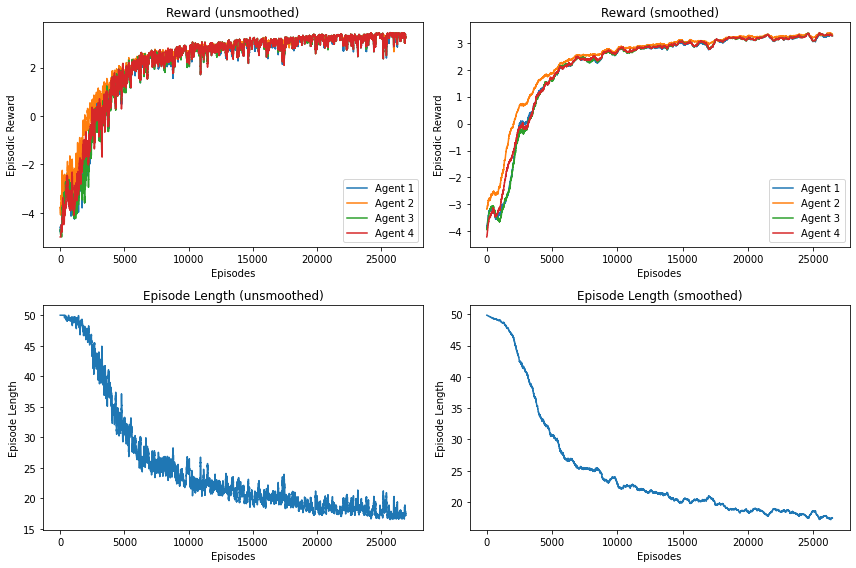

In [6]:
rough = 50
smooth = 500

reward_rough_1 = np.convolve(train_reward_1, np.ones((rough,))/rough, mode='valid')
reward_smooth_1 = np.convolve(train_reward_1, np.ones((smooth,))/smooth, mode='valid')

reward_rough_2 = np.convolve(train_reward_2, np.ones((rough,))/rough, mode='valid')
reward_smooth_2 = np.convolve(train_reward_2, np.ones((smooth,))/smooth, mode='valid')

reward_rough_3 = np.convolve(train_reward_3, np.ones((rough,))/rough, mode='valid')
reward_smooth_3 = np.convolve(train_reward_3, np.ones((smooth,))/smooth, mode='valid')

reward_rough_4 = np.convolve(train_reward_4, np.ones((rough,))/rough, mode='valid')
reward_smooth_4 = np.convolve(train_reward_4, np.ones((smooth,))/smooth, mode='valid')

length_rough = np.convolve(train_length, np.ones((rough,))/rough, mode='valid')
length_smooth = np.convolve(train_length, np.ones((smooth,))/smooth, mode='valid')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2,2,1)
ax.plot(reward_rough_1, label='Agent 1')
ax.plot(reward_rough_2, label='Agent 2')
ax.plot(reward_rough_3, label='Agent 3')
ax.plot(reward_rough_4, label='Agent 4')
ax.set_title("Reward (unsmoothed)")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes")
ax.legend()

ax = fig.add_subplot(2,2,2)
ax.plot(reward_smooth_1, label='Agent 1')
ax.plot(reward_smooth_2, label='Agent 2')
ax.plot(reward_smooth_3, label='Agent 3')
ax.plot(reward_smooth_4, label='Agent 4')
ax.set_title("Reward (smoothed)")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes")
ax.legend()

ax = fig.add_subplot(2,2,3)
ax.plot(length_rough)
ax.set_title("Episode Length (unsmoothed)")
ax.set_ylabel("Episode Length")
ax.set_xlabel("Episodes")

ax = fig.add_subplot(2,2,4)
ax.plot(length_smooth)
ax.set_title("Episode Length (smoothed)")
ax.set_ylabel("Episode Length")
ax.set_xlabel("Episodes")

plt.tight_layout()
plt.show()